In [38]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [39]:
days_past = -2 # days beyond the start of the data to plot
days_future = 20 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [40]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y


In [41]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [68]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    descr = '    fit: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'g-', label='prediction')
    ax.plot(date_xdata, ydata, 'b-', label='real data')

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')

    start = (len(ydata) - days_past - 1) % show_every
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

## Reading data

In [43]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [65]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

dates=pd.to_datetime(Spain.fecha.values)

last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

## Total confirmed cases

    fit: L=55518.215, k=0.285, x0=-0.183, y0=0.000
[6.87097295e+03 1.79497457e-02 7.97745274e-01 1.99565396e+02]


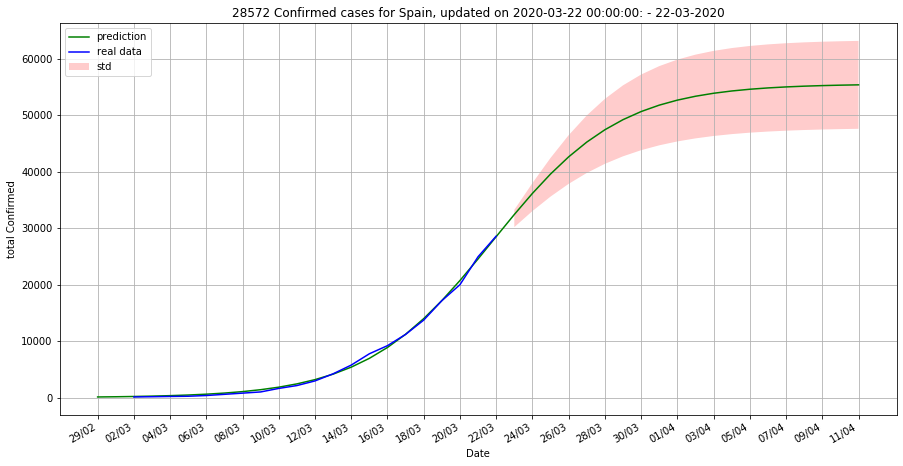

In [83]:
Titulo = '{:.0f} Confirmed cases for Spain, updated on {}:'.format(Confirmed[-1],dates[-1])
p_cont, err_cont = fit_curve(logistic, Confirmed, Titulo , 'total Confirmed', last_date, coeff_std);

Number of deaths 1720


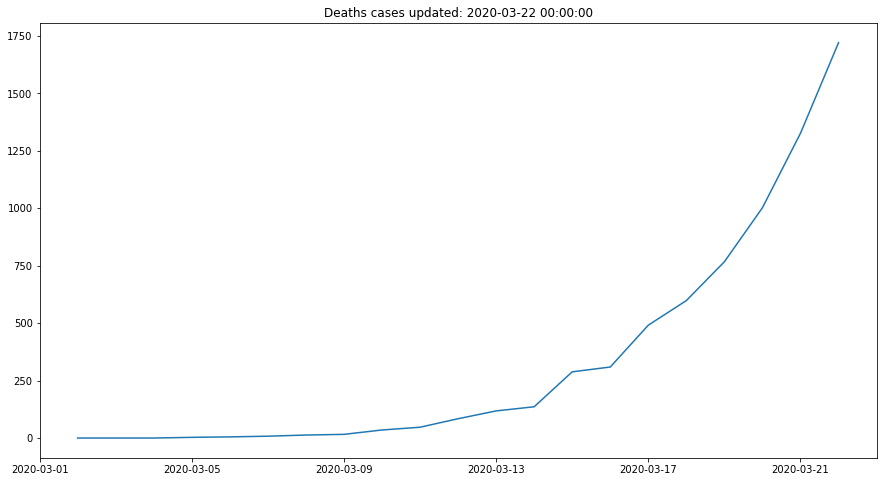

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Deaths)
ax.set_title("Deaths cases updated: {}".format(dates[-1]));
print('Number of deaths {:.0f}'.format(Deaths[-1]))

# Nuevos casos

## En toda España

    fit: L=66013.525, k=0.258, x0=1.447
[2.10817931e+04 4.66701970e-02 2.16648582e+00]


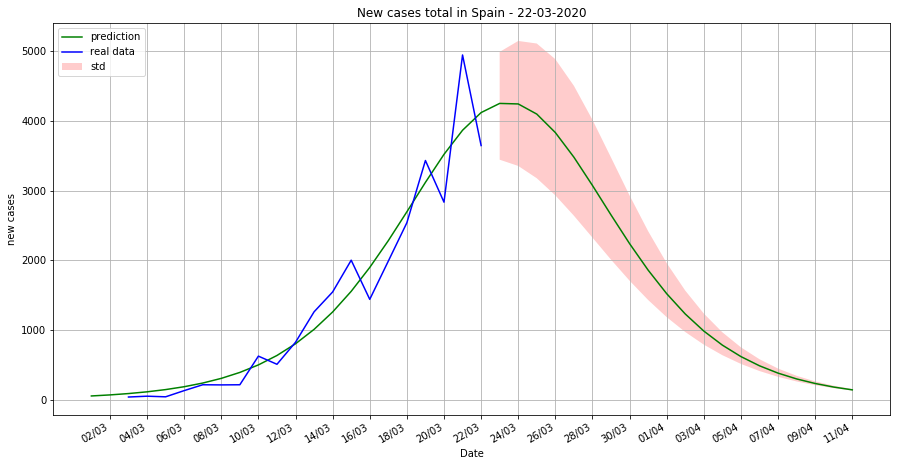

In [87]:
newCases=np.diff(Confirmed)

Titulo = '{:.0f} new cases for Spain, updated on {}:'.format(newCases[-1],dates[-1])
fit_curve(logistic_derivative, newCases, 'New cases total in Spain', 'new cases', last_date, coeff_std_d);

In [88]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newCases=tempVar
datesNewCases=dates[1:]

In [96]:
growth_factor = newCases[1:] / newCases[:-1]
dates_growth_factor = datesNewCases[1:]

### Growth rates in Spain

In [92]:
print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth factor for the last 5 days: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 0.737
Mean growth factor for the last 5 days: 1.188


### nuevos casos por CCAA ajustados a una logistic curve

    fit: L=2904.407, k=0.312, x0=-0.814
[5.93953947e+02 5.55139610e-02 1.15641117e+00]
    fit: L=199999.400, k=0.201, x0=29.946
[4.39488660e+07 1.12131511e-01 1.11358091e+03]
    fit: L=1385.042, k=0.276, x0=2.040
[1.29653932e+03 1.26571023e-01 5.86099332e+00]
    fit: L=199998.222, k=0.256, x0=25.432
[7.58056005e+07 1.50057516e-01 1.49539058e+03]
    fit: L=3001.751, k=0.321, x0=-0.057
[1.46980540e+03 1.19090996e-01 2.71115736e+00]
    fit: L=1451.462, k=0.252, x0=4.215
[9.69838112e+02 5.39182161e-02 4.27117677e+00]
    fit: L=290.029, k=1.061, x0=-0.779
[33.30157684  0.15006769  0.17538217]
    fit: L=200000.000, k=0.263, x0=18.396
[1.05746204e+07 1.14567080e-01 2.09827803e+02]
    fit: L=2641.465, k=0.454, x0=-0.701
[3.77574259e+02 6.03648014e-02 5.51975793e-01]
    fit: L=5889.933, k=0.515, x0=-1.870
[6.84027912e+02 7.12443244e-02 3.70960568e-01]
    fit: L=1.769, k=9.046, x0=-2.000
[17.78610439 90.95790361 10.05536357]


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in power
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


    fit: L=506.538, k=0.398, x0=-2.361
[5.82480198e+01 5.34160831e-02 4.78730034e-01]
    fit: L=6418.175, k=0.248, x0=7.613
[1.21638253e+04 7.04546364e-02 1.06946734e+01]
    fit: L=200000.000, k=0.098, x0=57.440
[5.18108059e+07 1.04188987e-01 2.71632177e+03]
    fit: L=17713.875, k=0.231, x0=-0.744
[7.44301647e+03 7.93190638e-02 3.20006743e+00]
    fit: L=24.100, k=0.910, x0=-4.917
[5.19307847 0.24221099 0.41621614]
    fit: L=1132.677, k=0.246, x0=4.558
[1.09944758e+03 7.24761511e-02 6.29169620e+00]
    fit: L=2729.217, k=0.220, x0=4.242
[2.45893483e+03 7.05868658e-02 6.72081158e+00]
    fit: L=199999.155, k=0.186, x0=24.856
[9.90787486e+06 9.36116332e-02 2.80733780e+02]


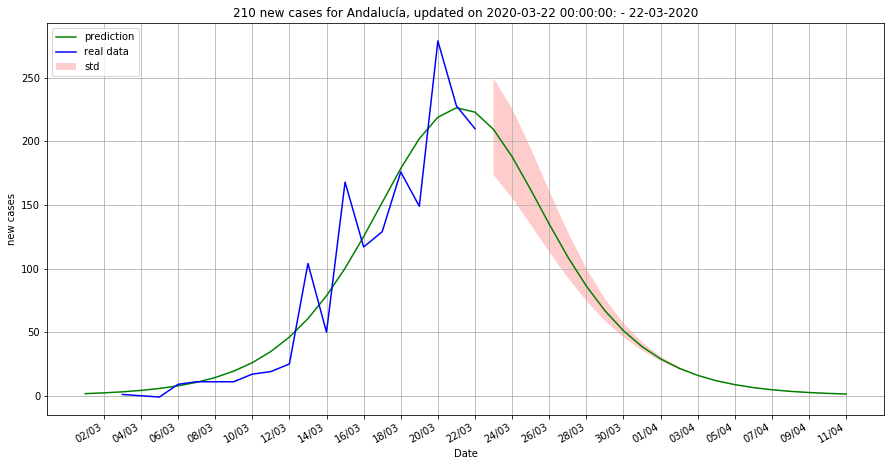

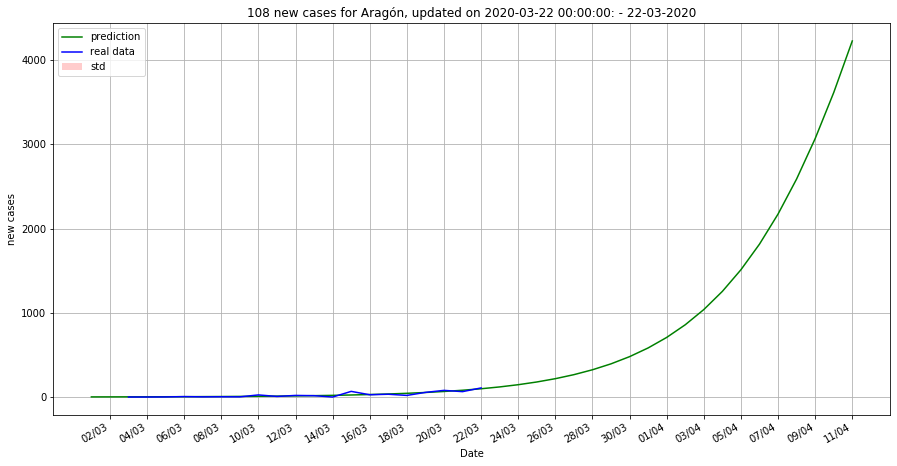

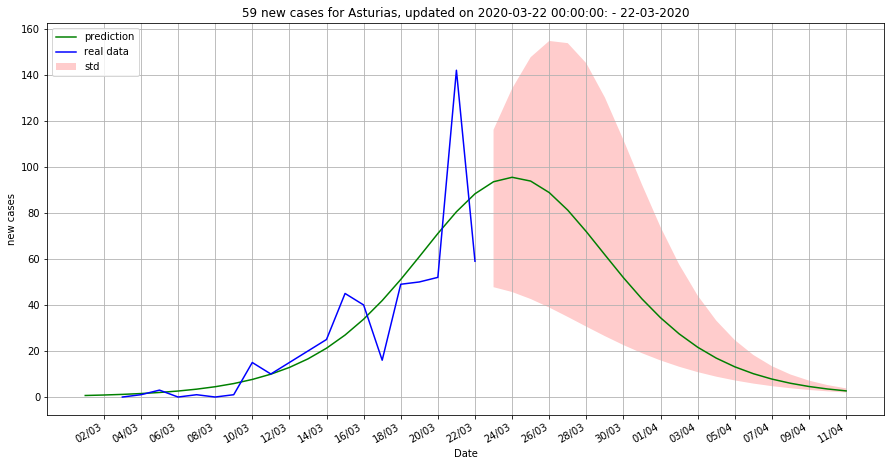

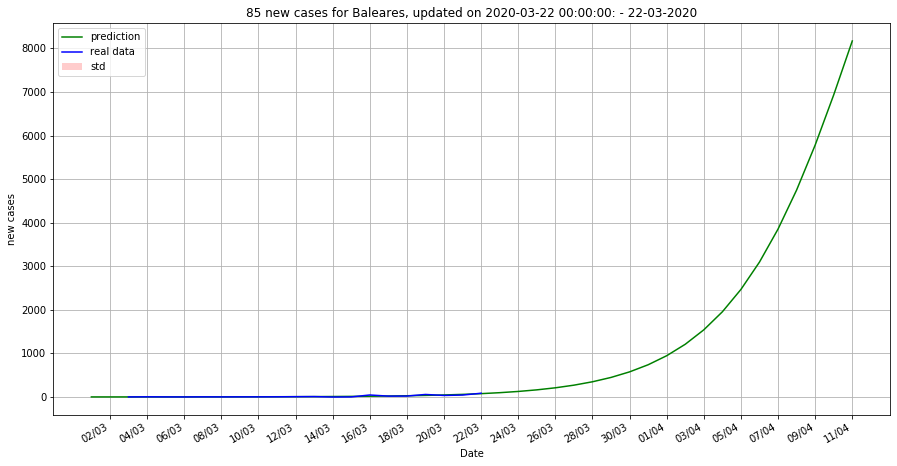

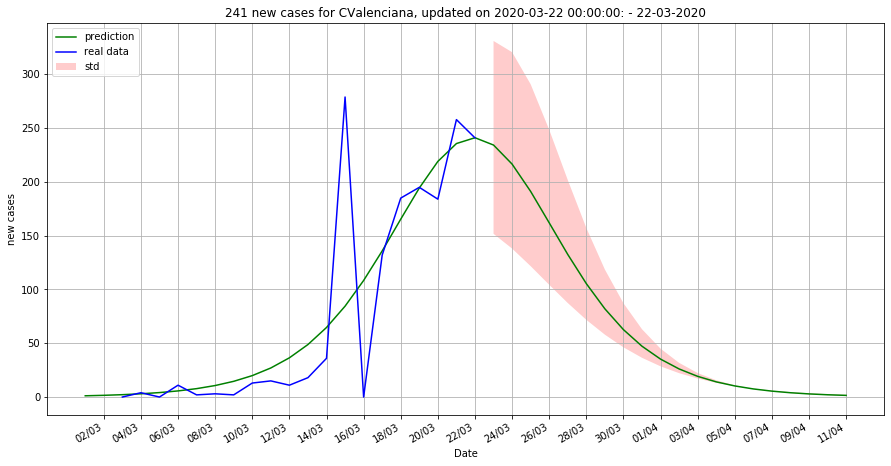

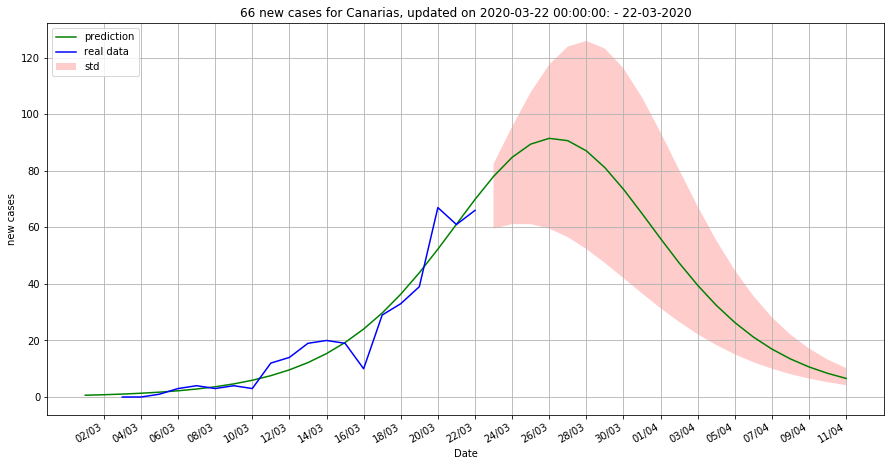

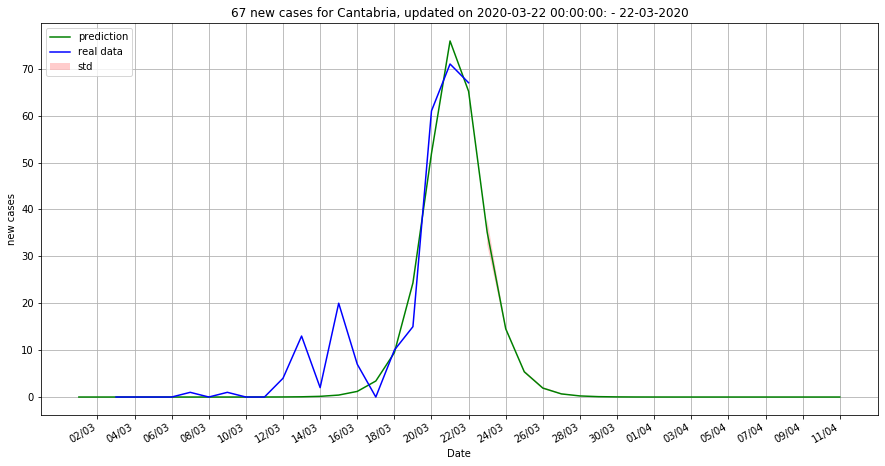

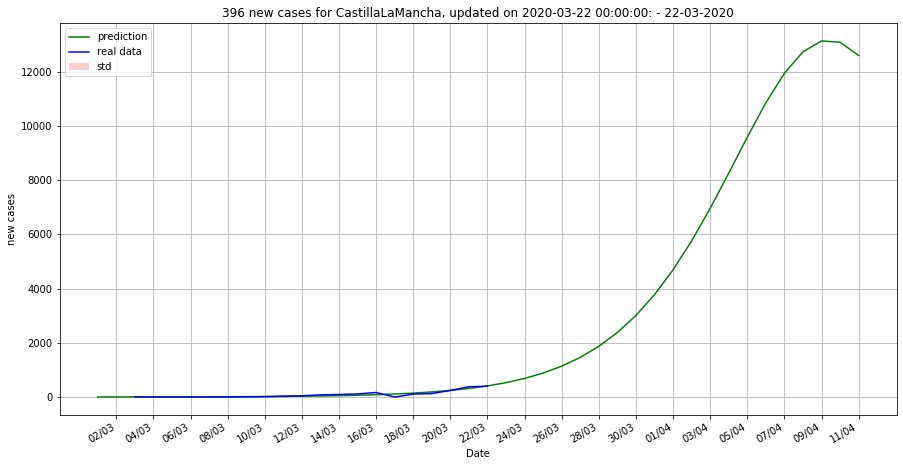

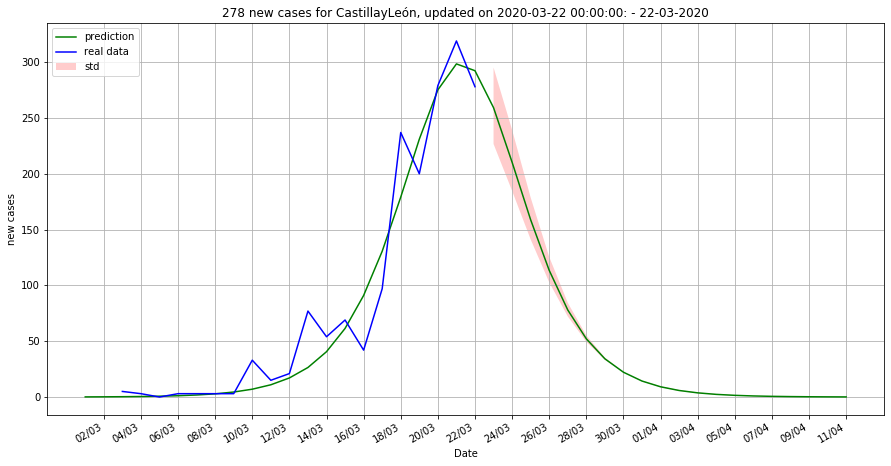

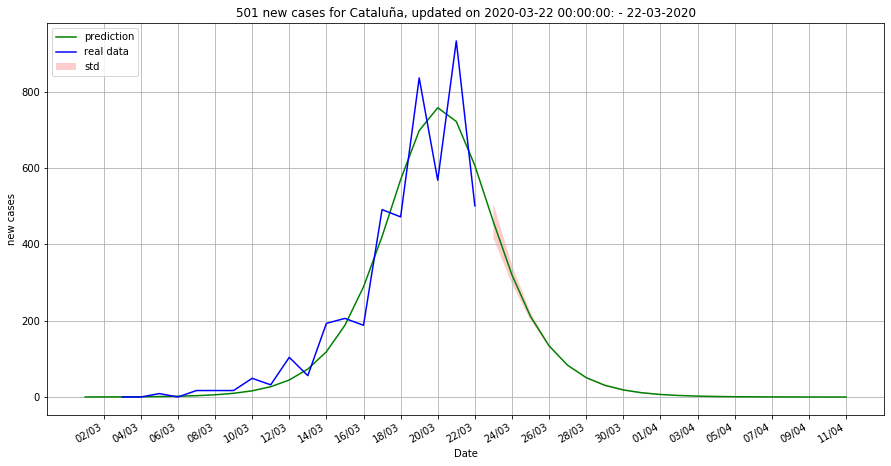

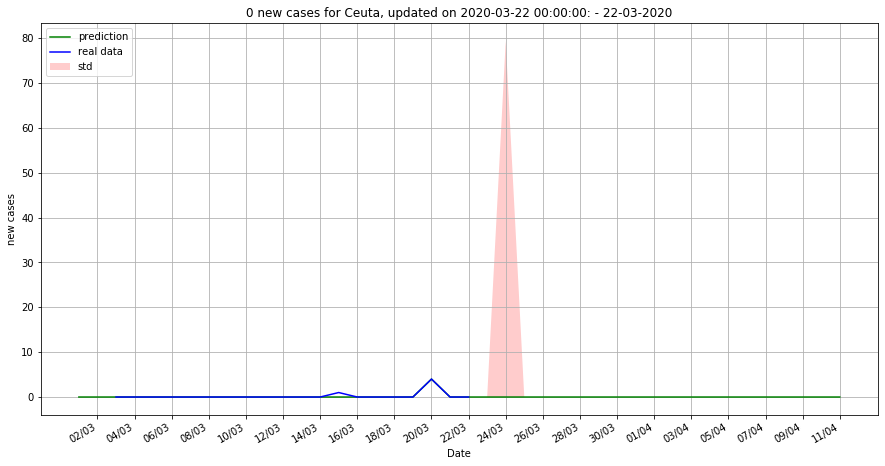

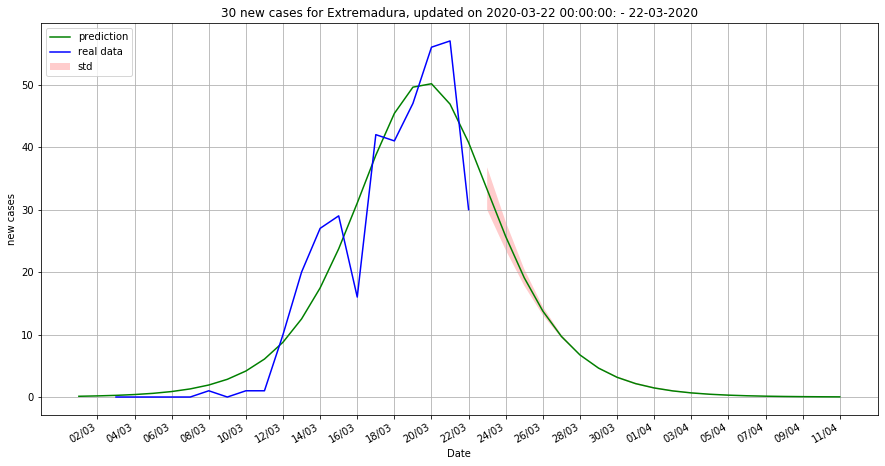

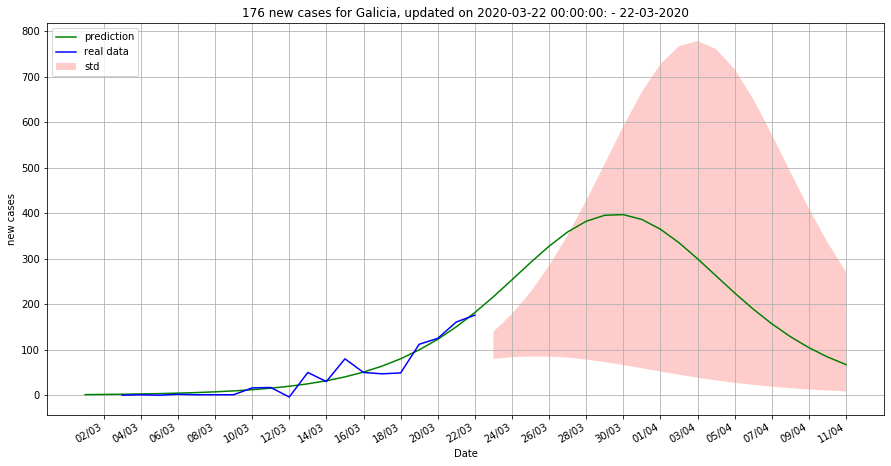

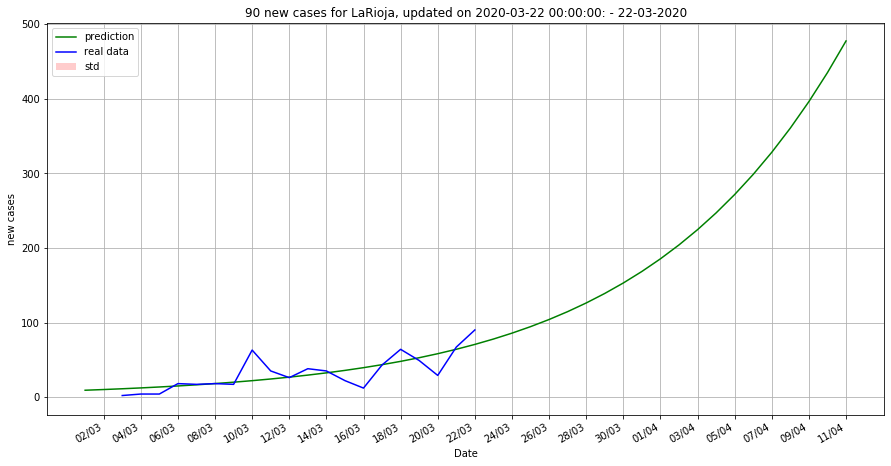

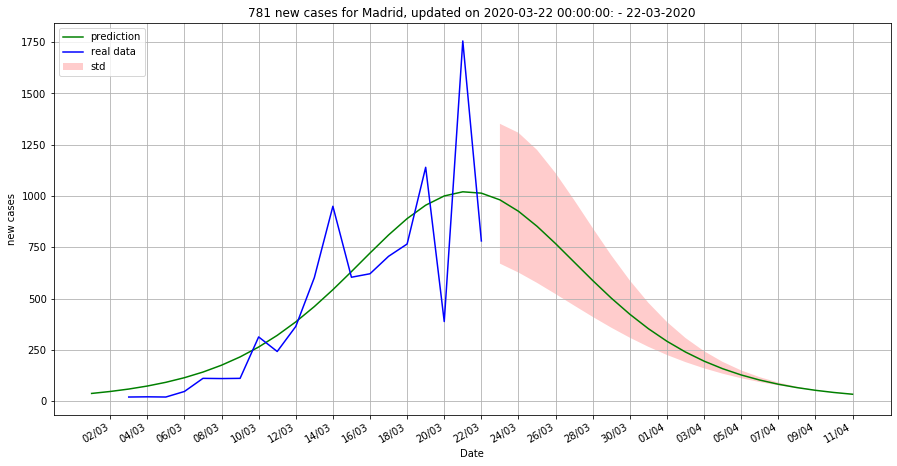

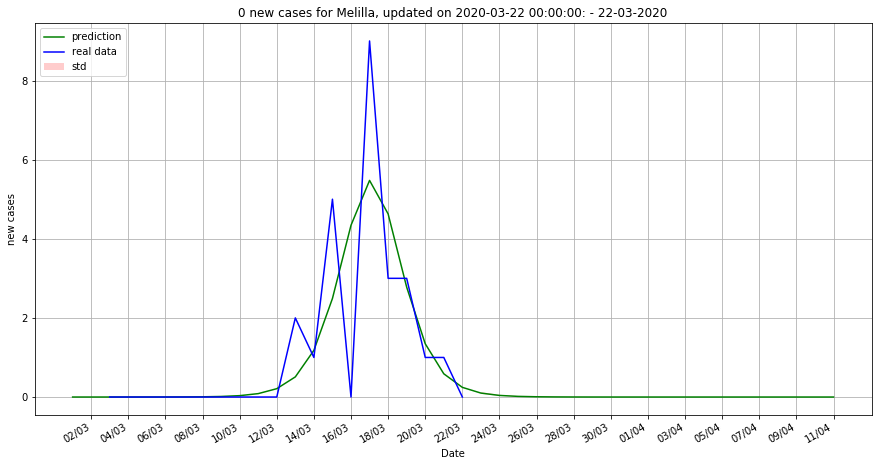

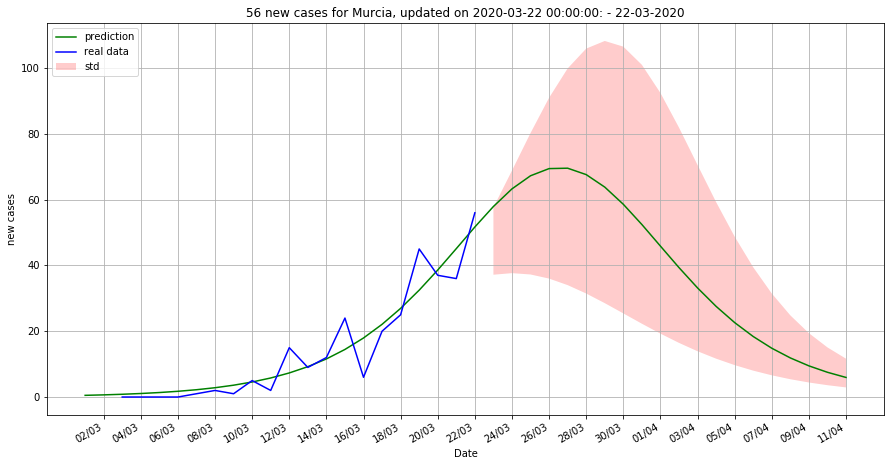

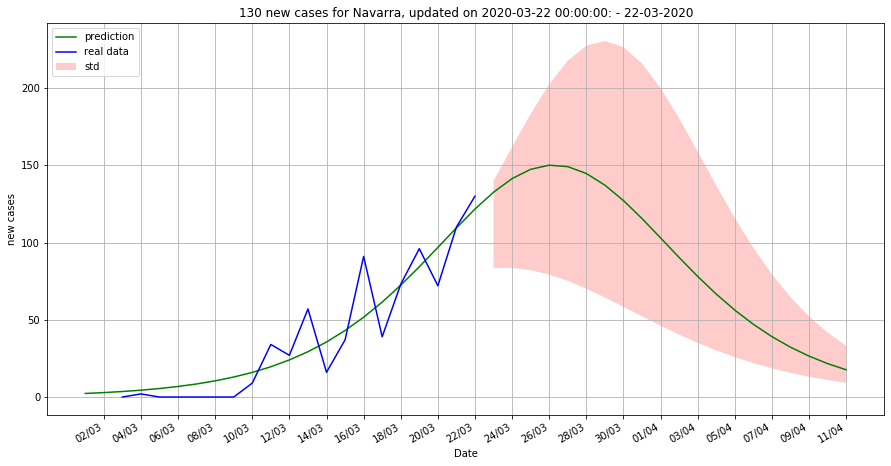

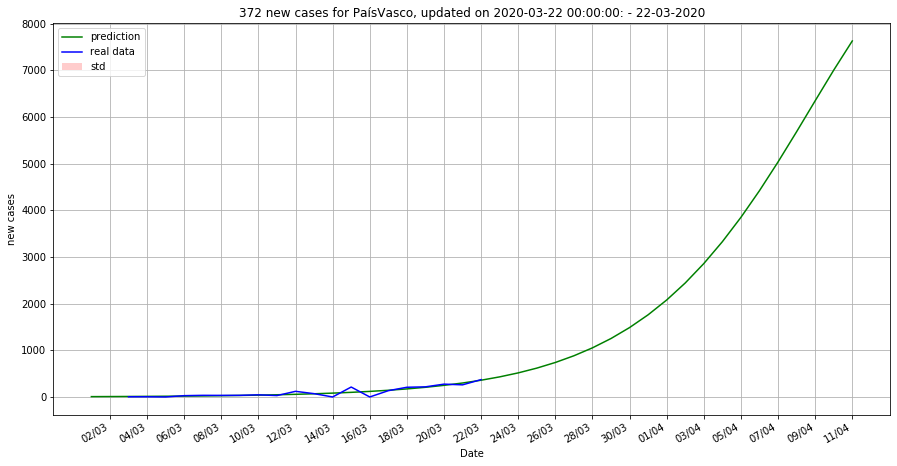

In [95]:
for CCAA in data.CCAA.unique():
    newCasesCCAA = np.diff(data[data.CCAA==CCAA].casos.values)
    Titulo = '{:.0f} new cases for {}, updated on {}:'.format(newCasesCCAA[-1],CCAA,dates[-1])
    fit_curve(logistic_derivative, newCasesCCAA, Titulo, 'new cases', last_date, coeff_std_d);